In [28]:
# ======================================================
# SCALABLE TERM ANALYSIS VERSION
# Supports unlimited new terms via TERM_MAP
# Year range fixed 2002–2026
# ======================================================

!pip -q install beautifulsoup4 pandas seaborn openpyxl numpy

from google.colab import drive
drive.mount('/content/drive')

import os
import re
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup

# ------------------------------
# CONFIGURATION
# ------------------------------

FOLDER_PATH = "/content/drive/MyDrive/PhD Files/DS301 Webpages"
START_YEAR = 2002
END_YEAR = 2026
ROLLING_WINDOW = 3

# ------------------------------
# TERM DICTIONARY (EDIT HERE)
# ------------------------------

TERM_MAP = {
    "artificial intelligence": [r'\bartificial intelligence\b', r'\bai\b'],
    "robotics": [r'\brobotics\b', r'\brobots\b'],
    "data science": [r'\bdata science\b'],
    "big data": [r'\bbig data\b'],
    "analytics": [r'\banalytics\b'],
    "data": [r'\bdata\b']
}

TERMS = list(TERM_MAP.keys())

# ------------------------------
# YEAR EXTRACTION
# ------------------------------

def extract_year(soup):

    for tag in soup.find_all("meta"):
        content = tag.get("content")
        if content:
            match = re.search(r'(20\d{2})', content)
            if match:
                return int(match.group(1))

    time_tag = soup.find("time")
    if time_tag:
        value = time_tag.get("datetime") or time_tag.get_text()
        match = re.search(r'(20\d{2})', str(value))
        if match:
            return int(match.group(1))

    for script in soup.find_all("script", type="application/ld+json"):
        try:
            data = json.loads(script.string)
            if isinstance(data, dict):
                date = data.get("datePublished") or data.get("dateCreated")
                if date:
                    match = re.search(r'(20\d{2})', date)
                    if match:
                        return int(match.group(1))
        except:
            continue

    return None

# ------------------------------
# PROCESS FILES
# ------------------------------

results = []

for filename in os.listdir(FOLDER_PATH):

    if filename.lower().endswith(".html"):

        filepath = os.path.join(FOLDER_PATH, filename)

        with open(filepath, "r", encoding="utf-8", errors="ignore") as f:
            html = f.read()

        soup = BeautifulSoup(html, "html.parser")
        text = soup.get_text().lower()
        text = re.sub(r'\s+', ' ', text)

        year = extract_year(soup)
        if year is None or year < START_YEAR or year > END_YEAR:
            continue

        word_count = len(text.split())

        record = {
            "year": year,
            "word_count": word_count
        }

        # Count using TERM_MAP
        for term, patterns in TERM_MAP.items():
            count = 0
            for pattern in patterns:
                count += len(re.findall(pattern, text))
            record[term] = count

        results.append(record)

df = pd.DataFrame(results)

if df.empty:
    raise ValueError("No valid articles found in 2002–2026.")

print("Total valid articles:", len(df))

# ----------------------------------------
# YEARLY AGGREGATION
# ----------------------------------------

yearly = df.groupby("year")[TERMS + ["word_count"]].sum().reset_index()

# Ensure complete year range
all_years = pd.DataFrame({"year": range(START_YEAR, END_YEAR + 1)})
yearly = all_years.merge(yearly, on="year", how="left").fillna(0)


# ----------------------------------------
# NORMALIZED FREQUENCY
# ----------------------------------------

for term in TERMS:
    yearly[term + "_norm"] = np.where(
        yearly["word_count"] == 0,
        0,
        yearly[term] / yearly["word_count"] * 10000
    )



# ----------------------------------------
# EXPORT TO EXCEL
# ----------------------------------------

output_path = "/content/drive/MyDrive/PhD Files/DS301 Webpages/term_analysis_scalable.xlsx"

with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
    df.to_excel(writer, sheet_name="Article_Level_Data", index=False)
    yearly.to_excel(writer, sheet_name="Yearly_Data", index=False)

print("Excel saved at:")
print(output_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Total valid articles: 283
Excel saved at:
/content/drive/MyDrive/PhD Files/DS301 Webpages/term_analysis_scalable.xlsx


In [2]:
# ----------------------------------------
# PROCESS HTML FILES
# ----------------------------------------

all_files = os.listdir(FOLDER_PATH)
html_files = [f for f in all_files if f.lower().endswith(".html")]

print("Total files in folder:", len(all_files))
print("Total HTML files found:", len(html_files))


results = []


Total files in folder: 314
Total HTML files found: 308


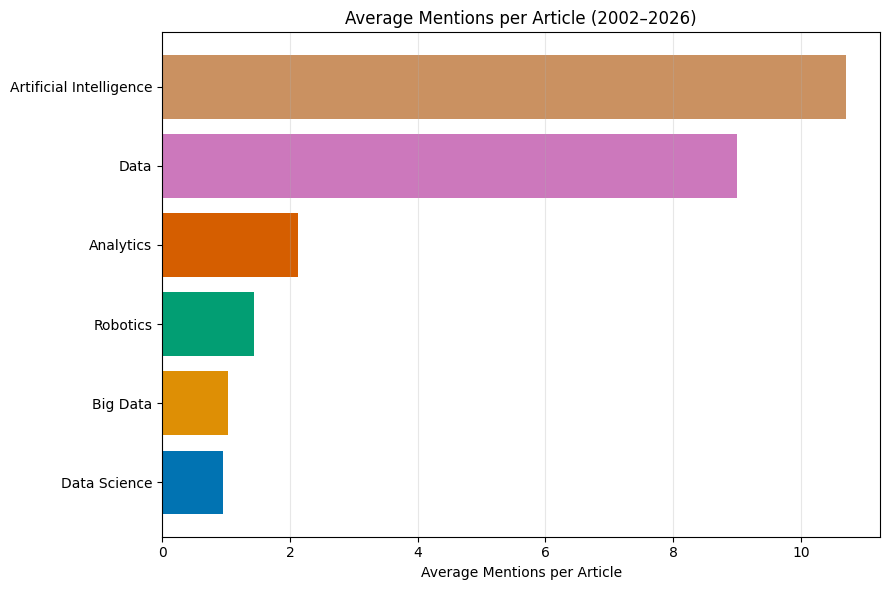

In [29]:
# ======================================================
# AVERAGE MENTIONS PER ARTICLE (2002–2026)
# ROBUST VERSION
# ======================================================

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Make sure year is a column
if 'year' not in df.columns:
    if df.index.name == 'year':
        df = df.reset_index()
    elif 'Year' in df.columns:
        df = df.rename(columns={'Year': 'year'})
    else:
        raise ValueError("No 'year' column found in dataframe.")

# Filter period
period_df = df[(df["year"] >= 2002) & (df["year"] <= 2026)]

if period_df.empty:
    raise ValueError("No articles found between 2002–2026.")

total_articles = len(period_df)

# Compute averages
avg_mentions = {}

for term in TERMS:
    if term not in period_df.columns:
        print(f"Warning: {term} not found in dataframe.")
        continue

    avg_mentions[term] = period_df[term].sum() / total_articles

avg_df = (
    pd.DataFrame(avg_mentions.items(), columns=["term", "avg_mentions"])
    .sort_values("avg_mentions", ascending=True)
)

# Title-case terms
avg_df["term"] = avg_df["term"].apply(lambda x: x.title())

# ------------------------------
# Plot
# ------------------------------

plt.figure(figsize=(9,6))

colors = sns.color_palette("colorblind", len(avg_df))

plt.barh(
    avg_df["term"],
    avg_df["avg_mentions"],
    color=colors
)

plt.xlabel("Average Mentions per Article")
plt.title("Average Mentions per Article (2002–2026)")
plt.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


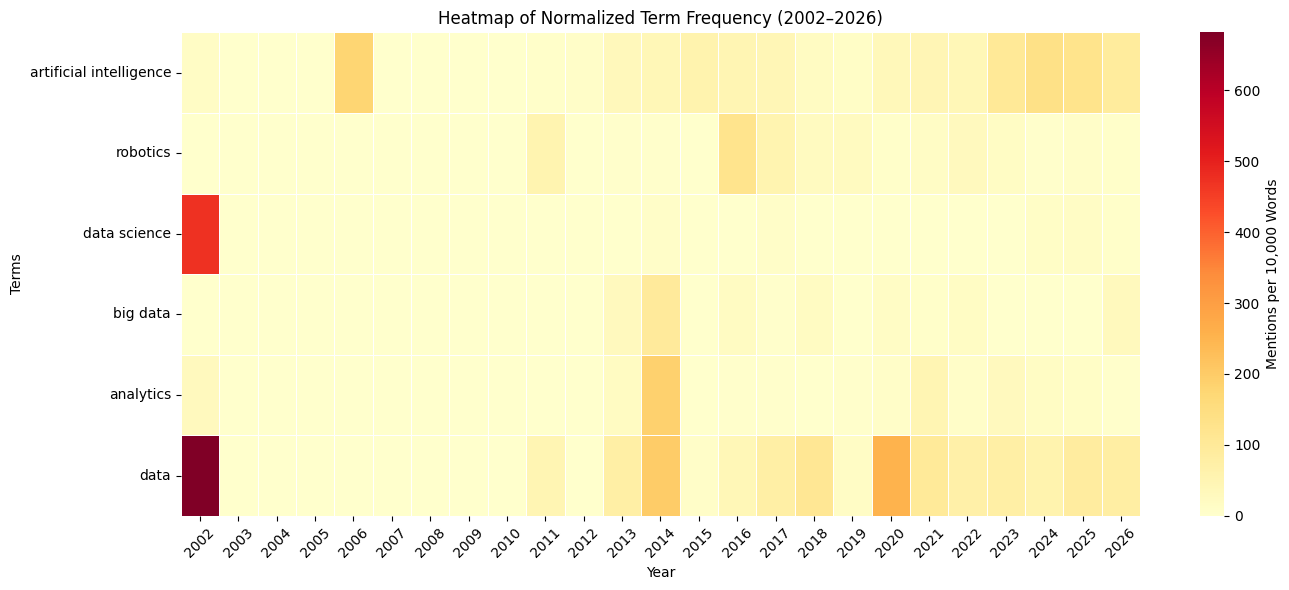

In [3]:
# ----------------------------------------
# HEATMAP: RAW NORMALIZED FREQUENCY
# ----------------------------------------

heat_raw = yearly.set_index("year")[
    [term + "_norm" for term in TERMS]
].T

# Clean labels
heat_raw.index = TERMS

plt.figure(figsize=(14,6))

sns.heatmap(
    heat_raw,
    cmap="YlOrRd",   # warmer scale for intensity
    linewidths=0.5,
    cbar_kws={"label": "Mentions per 10,000 Words"}
)

plt.xlabel("Year")
plt.ylabel("Terms")
plt.title("Heatmap of Normalized Term Frequency (2002–2026)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



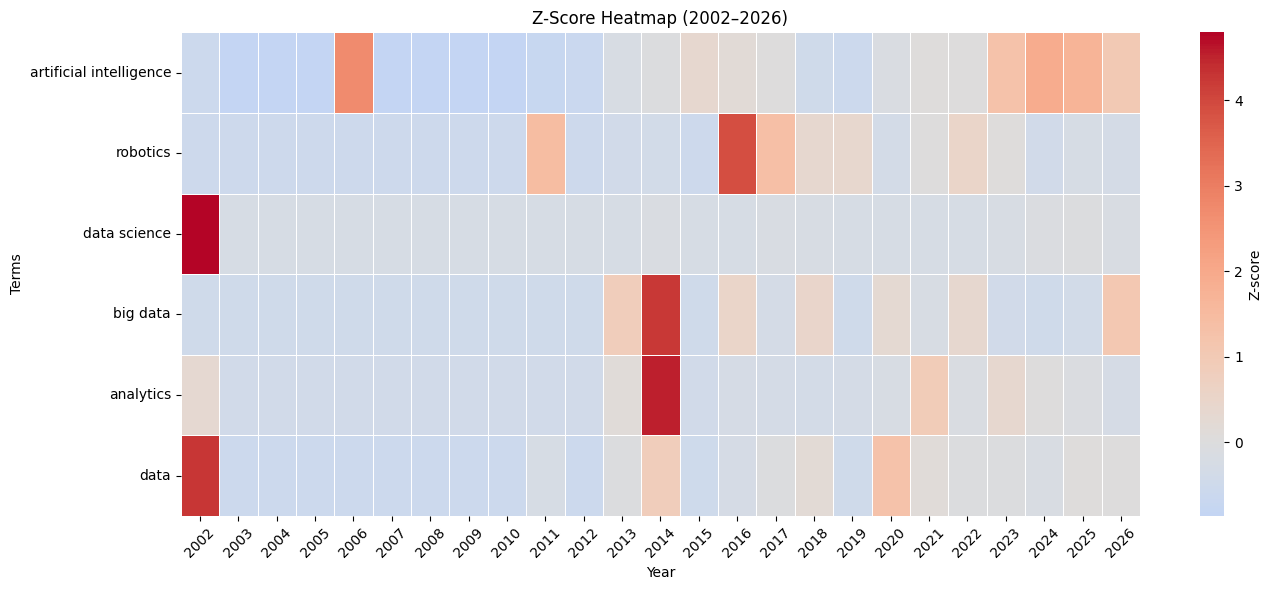

In [4]:
# ----------------------------------------
# Z-SCORE HEATMAP
# ----------------------------------------

zscore_df = yearly.copy()

for term in TERMS:
    mean = zscore_df[term + "_norm"].mean()
    std = zscore_df[term + "_norm"].std()

    if std == 0 or np.isnan(std):
        zscore_df[term + "_z"] = 0
    else:
        zscore_df[term + "_z"] = (
            (zscore_df[term + "_norm"] - mean) / std
        )

heat_data = zscore_df.set_index("year")[
    [term + "_z" for term in TERMS]
].T.fillna(0)

heat_data.index = TERMS

plt.figure(figsize=(14,6))

sns.heatmap(
    heat_data,
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    cbar_kws={"label": "Z-score"}
)

plt.xlabel("Year")
plt.ylabel("Terms")
plt.title("Z-Score Heatmap (2002–2026)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


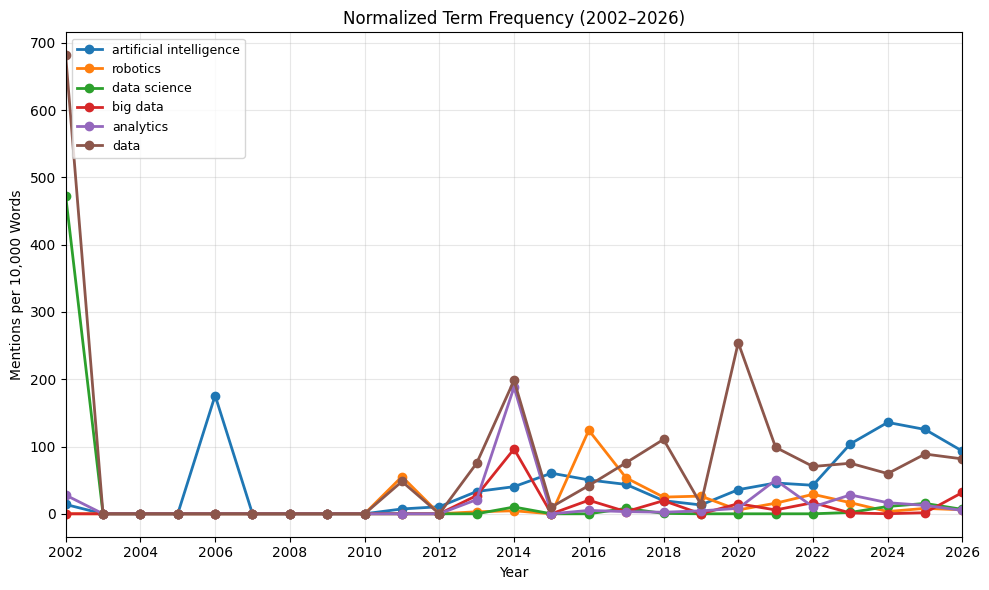

In [5]:
# ----------------------------------------
# RAW NORMALIZED PLOT
# ----------------------------------------

plt.figure(figsize=(10,6))

for term in TERMS:
    plt.plot(yearly["year"], yearly[term + "_norm"], marker='o', linewidth=2, label=term)

plt.xlim(START_YEAR, END_YEAR)
plt.xticks(range(START_YEAR, END_YEAR + 1, 2))
plt.xlabel("Year")
plt.ylabel("Mentions per 10,000 Words")
plt.title("Normalized Term Frequency (2002–2026)")
plt.grid(True, alpha=0.3)
plt.legend(loc="upper left", fontsize=9)
plt.tight_layout()
plt.show()

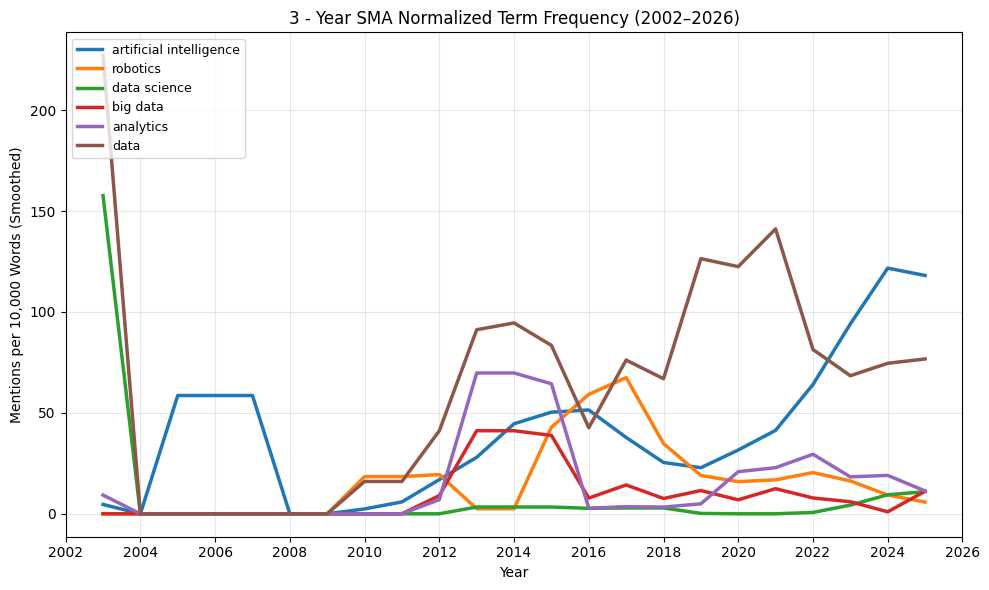

In [6]:
# ----------------------------------------
# SMOOTHED PLOT
# ----------------------------------------
ROLLING_WINDOW = 3

for term in TERMS:
    yearly[term + "_smooth"] = yearly[term + "_norm"].rolling(
        window=ROLLING_WINDOW, center=True
    ).mean()

plt.figure(figsize=(10,6))

for term in TERMS:
    plt.plot(yearly["year"], yearly[term + "_smooth"], linewidth=2.5, label=term)

plt.xlim(START_YEAR, END_YEAR)
plt.xticks(range(START_YEAR, END_YEAR + 1, 2))
plt.xlabel("Year")
plt.ylabel("Mentions per 10,000 Words (Smoothed)")
plt.title("3 - Year SMA Normalized Term Frequency (2002–2026)")
plt.grid(True, alpha=0.3)
plt.legend(loc="upper left", fontsize=9)
plt.tight_layout()
plt.show()

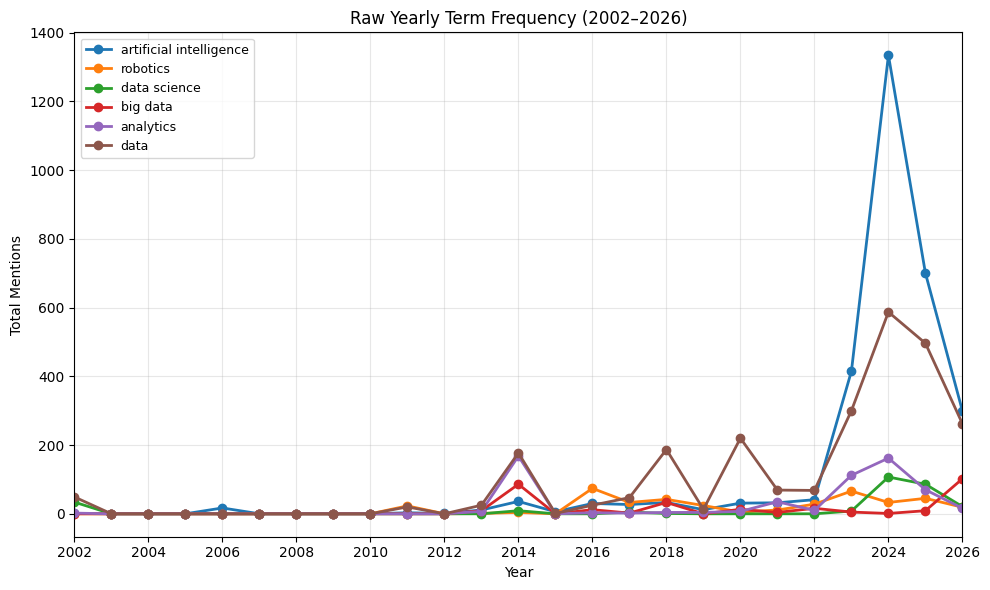

In [8]:
# ----------------------------------------
# RAW YEARLY FREQUENCY PLOT (2002–2026)
# ----------------------------------------

# Ensure full year range
all_years = pd.DataFrame({"year": range(2002, 2027)})
yearly = all_years.merge(yearly, on="year", how="left").fillna(0)

plt.figure(figsize=(10,6))

for term in TERMS:
    plt.plot(
        yearly["year"],
        yearly[term],
        marker='o',
        linewidth=2,
        label=term
    )

plt.xlim(2002, 2026)
plt.xticks(range(2002, 2027, 2))
plt.xlabel("Year")
plt.ylabel("Total Mentions")
plt.title("Raw Yearly Term Frequency (2002–2026)")
plt.grid(True, alpha=0.3)
plt.legend(loc="upper left", fontsize=9)
plt.tight_layout()
plt.show()



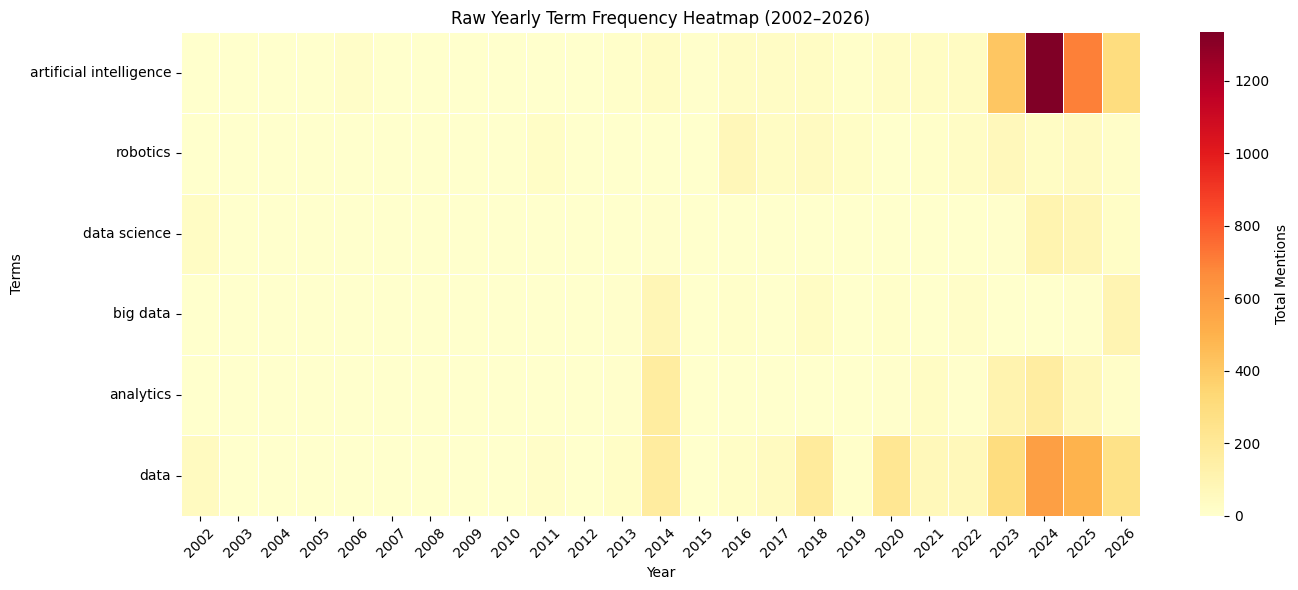

In [9]:
yearly = df.groupby("year")[TERMS].sum().reset_index()
# ----------------------------------------
# RAW FREQUENCY HEATMAP (2002–2026)
# ----------------------------------------

# Ensure full year range
all_years = pd.DataFrame({"year": range(2002, 2027)})
yearly = all_years.merge(yearly, on="year", how="left").fillna(0)

# Prepare heatmap data
heat_raw = yearly.set_index("year")[TERMS].T

plt.figure(figsize=(14,6))

sns.heatmap(
    heat_raw,
    cmap="YlOrRd",   # Sequential color for magnitude
    linewidths=0.5,
    cbar_kws={"label": "Total Mentions"}
)

plt.xlabel("Year")
plt.ylabel("Terms")
plt.title("Raw Yearly Term Frequency Heatmap (2002–2026)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


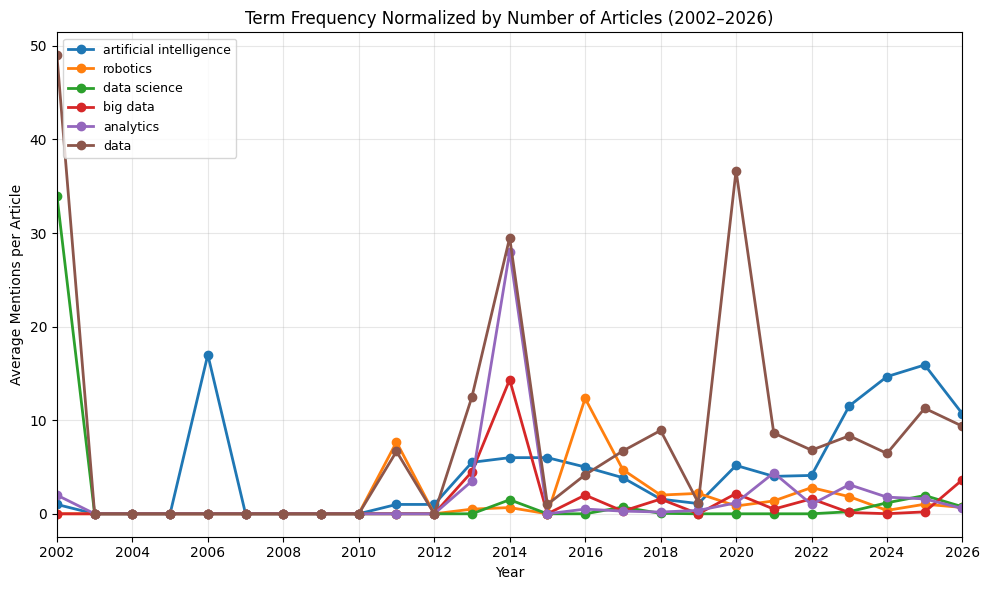

In [10]:
yearly_counts = df.groupby("year").size().reset_index(name="article_count")
yearly_terms = df.groupby("year")[TERMS].sum().reset_index()

yearly = pd.merge(yearly_terms, yearly_counts, on="year")

for term in TERMS:
    yearly[term + "_per_article"] = np.where(
        yearly["article_count"] == 0,
        0,
        yearly[term] / yearly["article_count"]
    )

# ----------------------------------------
# NORMALIZED BY NUMBER OF ARTICLES
# ----------------------------------------

# Ensure full year range
all_years = pd.DataFrame({"year": range(2002, 2027)})

yearly_counts = df.groupby("year").size().reset_index(name="article_count")
yearly_terms = df.groupby("year")[TERMS].sum().reset_index()

yearly = pd.merge(yearly_terms, yearly_counts, on="year")

yearly = all_years.merge(yearly, on="year", how="left").fillna(0)

# Compute average mentions per article
for term in TERMS:
    yearly[term + "_per_article"] = np.where(
        yearly["article_count"] == 0,
        0,
        yearly[term] / yearly["article_count"]
    )

# ----------------------------------------
# PLOT
# ----------------------------------------

plt.figure(figsize=(10,6))

for term in TERMS:
    plt.plot(
        yearly["year"],
        yearly[term + "_per_article"],
        marker='o',
        linewidth=2,
        label=term
    )

plt.xlim(2002, 2026)
plt.xticks(range(2002, 2027, 2))
plt.xlabel("Year")
plt.ylabel("Average Mentions per Article")
plt.title("Term Frequency Normalized by Number of Articles (2002–2026)")
plt.grid(True, alpha=0.3)
plt.legend(loc="upper left", fontsize=9)
plt.tight_layout()
plt.show()


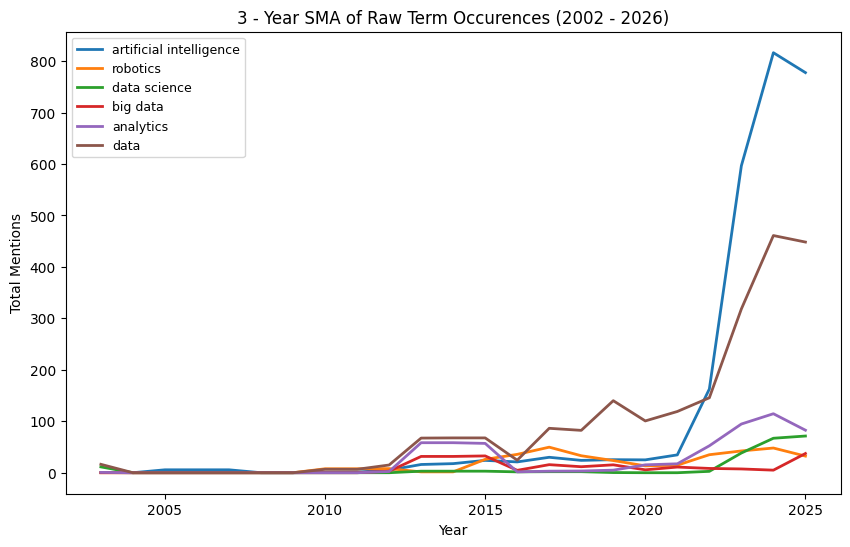

In [11]:
# ----------------------------------------
# SMOOTHED
# ----------------------------------------

plt.figure(figsize=(10,6))

for term in TERMS:
    smoothed = yearly[term].rolling(window=3, center=True).mean()
    plt.plot(yearly["year"], smoothed, linewidth=2, label=term)

plt.xlabel("Year")
plt.ylabel("Total Mentions")
plt.title("3 - Year SMA of Raw Term Occurences (2002 - 2026)")
plt.legend(loc="upper left", fontsize=9)
plt.show()


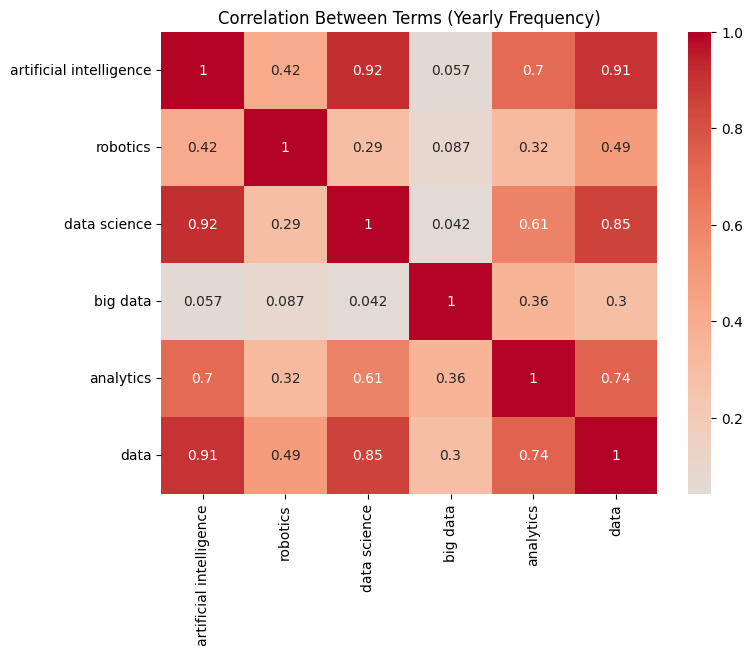

In [12]:
# ----------------------------------------
# CORRELATION HEATMAP
# ----------------------------------------

corr_matrix = yearly[TERMS].corr()

plt.figure(figsize=(8,6))

sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    center=0
)

plt.title("Correlation Between Terms (Yearly Frequency)")
plt.show()


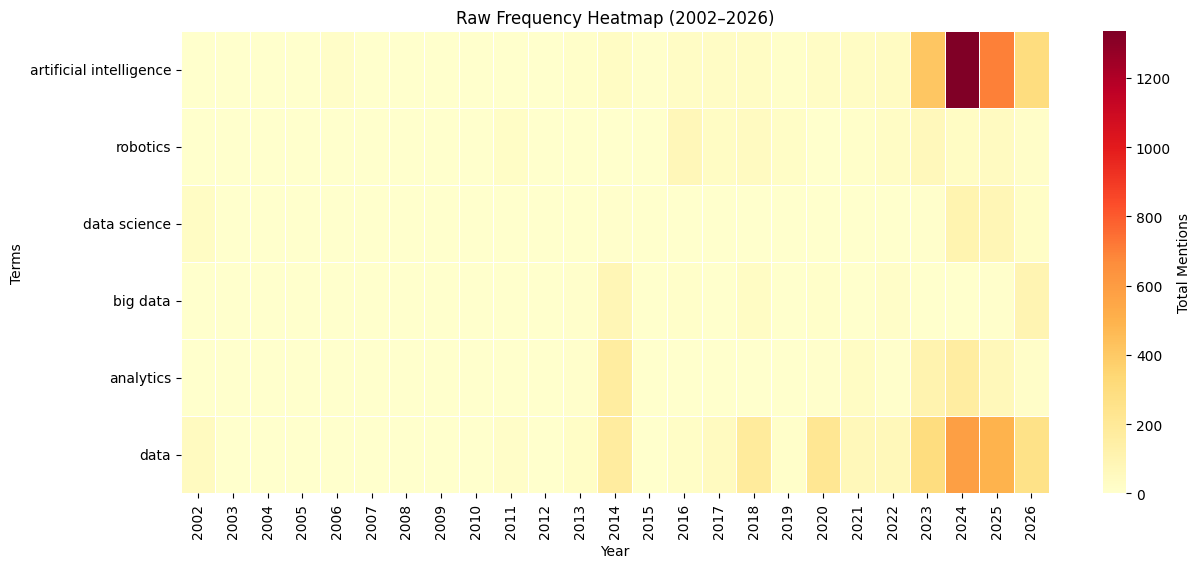

In [13]:
# ----------------------------------------
# RAW FREQUENCY HEATMAP
# ----------------------------------------

heat_raw = yearly.set_index("year")[TERMS].T

plt.figure(figsize=(14,6))

sns.heatmap(
    heat_raw,
    cmap="YlOrRd",
    linewidths=0.5,
    cbar_kws={"label": "Total Mentions"}
)

plt.xlabel("Year")
plt.ylabel("Terms")
plt.title("Raw Frequency Heatmap (2002–2026)")
plt.show()


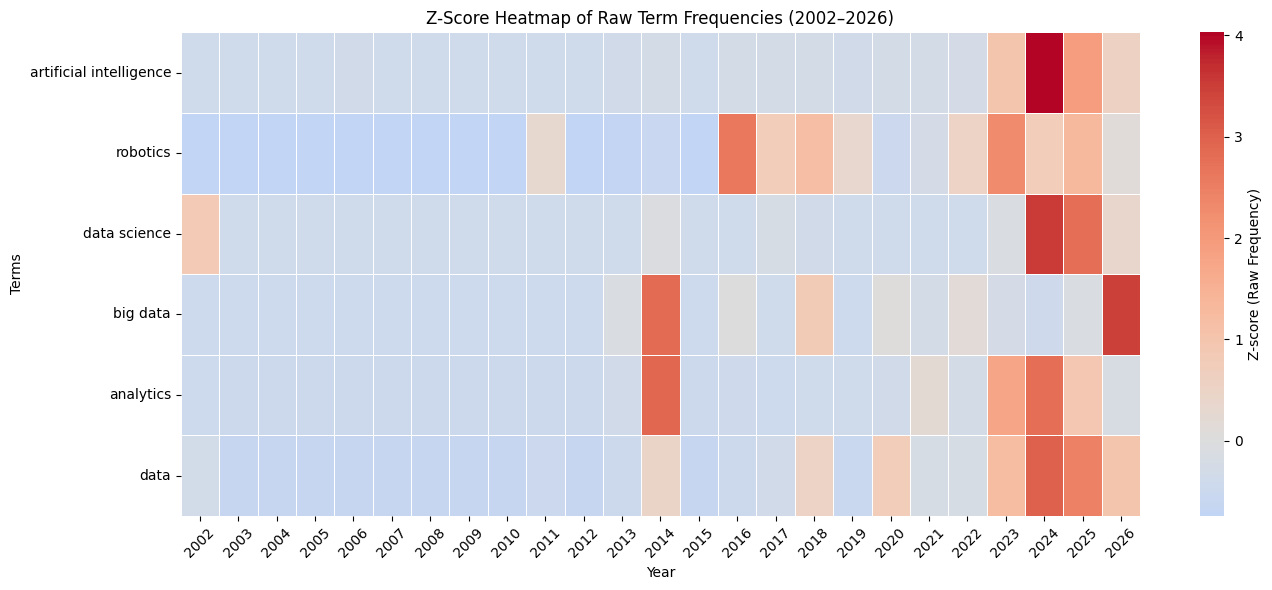

In [14]:
# ----------------------------------------
# Z-SCORE HEATMAP (RAW TERM FREQUENCIES)
# ----------------------------------------

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure complete year range
all_years = pd.DataFrame({"year": range(2002, 2027)})
yearly = all_years.merge(yearly, on="year", how="left").fillna(0)

# ----------------------------------------
# COMPUTE Z-SCORES (FROM RAW COUNTS)
# ----------------------------------------

zscore_df = yearly.copy()

for term in TERMS:
    mean = zscore_df[term].mean()
    std = zscore_df[term].std()

    if std == 0 or np.isnan(std):
        zscore_df[term + "_z"] = 0
    else:
        zscore_df[term + "_z"] = (
            (zscore_df[term] - mean) / std
        )

# ----------------------------------------
# PREPARE HEATMAP DATA
# ----------------------------------------

heat_data = zscore_df.set_index("year")[
    [term + "_z" for term in TERMS]
].T.fillna(0)

# Clean labels (remove _z)
heat_data.index = TERMS

# ----------------------------------------
# PLOT HEATMAP
# ----------------------------------------

plt.figure(figsize=(14,6))

sns.heatmap(
    heat_data,
    cmap="coolwarm",      # diverging for positive/negative deviation
    center=0,
    linewidths=0.5,
    cbar_kws={"label": "Z-score (Raw Frequency)"}
)

plt.xlabel("Year")
plt.ylabel("Terms")
plt.title("Z-Score Heatmap of Raw Term Frequencies (2002–2026)")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [16]:
# ======================================================
# DOMAIN FREQUENCY TABLE (DISPLAY + EXPORT TO EXCEL)
# ======================================================

!pip -q install beautifulsoup4 pandas openpyxl

from google.colab import drive
drive.mount('/content/drive')

import os
import re
import json
import pandas as pd
from bs4 import BeautifulSoup
from urllib.parse import urlparse

# ------------------------------
# CONFIGURATION
# ------------------------------

FOLDER_PATH = "/content/drive/MyDrive/PhD Files/DS301 Webpages"
START_YEAR = 2002
END_YEAR = 2026

# ------------------------------
# YEAR EXTRACTION FUNCTION
# ------------------------------

def extract_year(soup):
    for tag in soup.find_all("meta"):
        content = tag.get("content")
        if content:
            match = re.search(r'(20\d{2})', content)
            if match:
                return int(match.group(1))
    return None

# ------------------------------
# PROCESS HTML FILES
# ------------------------------

all_files = os.listdir(FOLDER_PATH)
html_files = [f for f in all_files if f.lower().endswith(".html")]

results = []

for filename in html_files:

    filepath = os.path.join(FOLDER_PATH, filename)

    with open(filepath, "r", encoding="utf-8", errors="ignore") as f:
        html = f.read()

    soup = BeautifulSoup(html, "html.parser")

    year = extract_year(soup)
    if year is None or year < START_YEAR or year > END_YEAR:
        continue

    # Extract domain
    domain = "unknown"

    meta_url = soup.find("meta", property="og:url")
    if meta_url and meta_url.get("content"):
        parsed = urlparse(meta_url["content"])
        domain = parsed.netloc
    elif soup.find("link", rel="canonical"):
        canonical = soup.find("link", rel="canonical").get("href")
        if canonical:
            parsed = urlparse(canonical)
            domain = parsed.netloc

    domain = domain.replace("www.", "")

    results.append({"domain": domain})

# ------------------------------
# CREATE FREQUENCY TABLE
# ------------------------------

df = pd.DataFrame(results)

domain_counts = df["domain"].value_counts().reset_index()
domain_counts.columns = ["domain", "article_count"]

# Display table
print("Domain Frequency Table (2002–2026):\n")
print(domain_counts)

# ------------------------------
# EXPORT TO EXCEL
# ------------------------------

output_path = "/content/drive/MyDrive/PhD Files/DS301 Webpages/domain_frequency_table.xlsx"

domain_counts.to_excel(output_path, index=False)

print("\nExcel file saved at:")
print(output_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Domain Frequency Table (2002–2026):

                        domain  article_count
0               gmanetwork.com            106
1      technology.inquirer.net             46
2        business.inquirer.net             13
3                   pna.gov.ph             12
4                  abs-cbn.com              9
5                 philstar.com              9
6               fintechnews.ph              8
7                    mb.com.ph              7
8           manilastandard.net              6
9             bworldonline.com              6
10        opinion.inquirer.net              5
11                    felta.ph              3
12       businessmirror.com.ph              3
13       newsinfo.inquirer.net              3
14                  dmaiph.com              3
15                 rappler.com              2
16                  ateneo.edu              2
17    

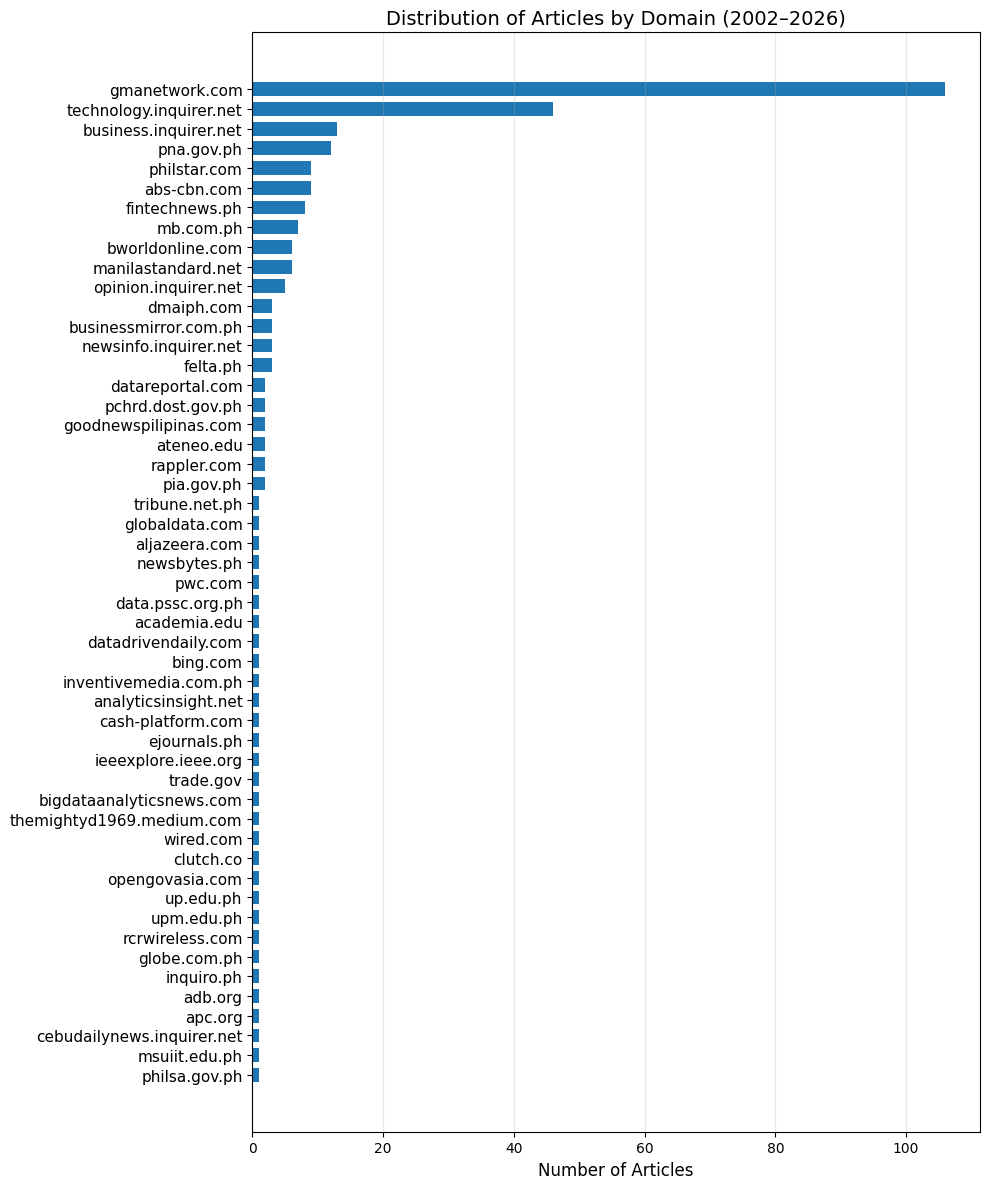

In [20]:
# ----------------------------------------
# HORIZONTAL BAR CHART – IMPROVED READABILITY
# ----------------------------------------

import matplotlib.pyplot as plt

# Sort ascending so largest appears at top
domain_counts_sorted = domain_counts.sort_values(
    by="article_count",
    ascending=True
)

plt.figure(figsize=(10, 12))  # Increased height

bars = plt.barh(
    domain_counts_sorted["domain"],
    domain_counts_sorted["article_count"],
    height=0.7  # Control spacing between bars (smaller = more spacing)
)

plt.xlabel("Number of Articles", fontsize=12)
plt.title("Distribution of Articles by Domain (2002–2026)", fontsize=14)

plt.yticks(fontsize=11)  # Larger domain font
plt.grid(axis="x", alpha=0.3)

# Adjust left margin so domain text doesn't get cut
plt.subplots_adjust(left=0.35)

plt.tight_layout()
plt.show()


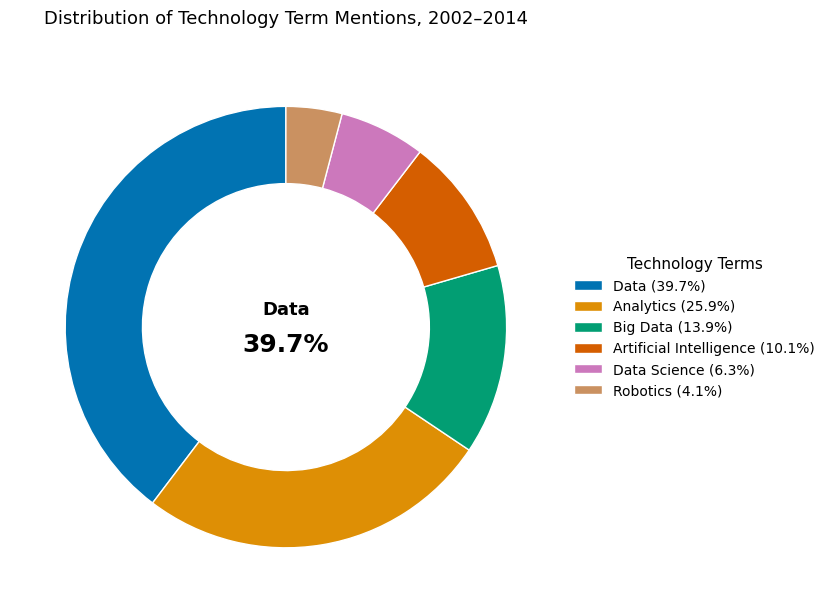

In [32]:
# ======================================================
# JOURNAL-QUALITY DONUT WITH TITLE-CASE LEGEND (2002–2014)
# ======================================================

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# ------------------------------
# Prepare Data (2002–2014)
# ------------------------------

if "year" not in yearly.columns:
    yearly = yearly.reset_index()

period_data = yearly[
    (yearly["year"] >= 2002) &
    (yearly["year"] <= 2014)
]

term_totals = period_data[TERMS].sum()
term_totals = term_totals.sort_values(ascending=False)

# Group small categories (<3%) into "Others"
total_sum = term_totals.sum()
percentages = term_totals / total_sum * 100

threshold = 3
major_terms = term_totals[percentages >= threshold]
minor_terms = term_totals[percentages < threshold]

if len(minor_terms) > 0:
    major_terms["Others"] = minor_terms.sum()

term_totals = major_terms
percentages = term_totals / term_totals.sum() * 100

# Dominant term
dominant_term = term_totals.idxmax().title()
dominant_pct = percentages.max()

# ------------------------------
# Plot Styling
# ------------------------------

colors = sns.color_palette("colorblind", len(term_totals))

fig, ax = plt.subplots(figsize=(8,7))

wedges, _ = ax.pie(
    term_totals.values,
    startangle=90,
    colors=colors,
    wedgeprops=dict(width=0.35, edgecolor='white')
)

# ------------------------------
# Center Highlight
# ------------------------------

ax.text(
    0, 0.08,
    dominant_term,
    ha='center',
    va='center',
    fontsize=13,
    weight='bold'
)

ax.text(
    0, -0.08,
    f"{dominant_pct:.1f}%",
    ha='center',
    va='center',
    fontsize=18,
    weight='bold'
)

# ------------------------------
# Legend (Title Case Labels)
# ------------------------------

legend_labels = [
    f"{term.title()} ({percentages.iloc[i]:.1f}%)"
    for i, term in enumerate(term_totals.index)
]

ax.legend(
    wedges,
    legend_labels,
    title="Technology Terms",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    frameon=False,
    fontsize=10,
    title_fontsize=11
)

# ------------------------------
# Final Layout
# ------------------------------

ax.set_title(
    "Distribution of Technology Term Mentions, 2002–2014",
    fontsize=13,
    pad=20
)

plt.tight_layout()
plt.show()


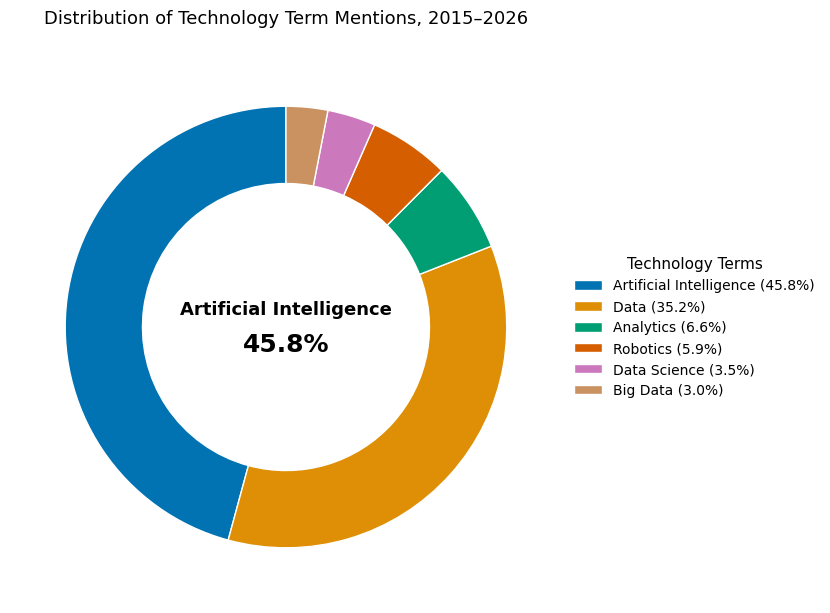

In [33]:
# ======================================================
# JOURNAL-QUALITY DONUT WITH TITLE-CASE LEGEND (2015–2026)
# ======================================================

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# ------------------------------
# Prepare Data (2015–2026)
# ------------------------------

if "year" not in yearly.columns:
    yearly = yearly.reset_index()

period_data = yearly[
    (yearly["year"] >= 2015) &
    (yearly["year"] <= 2026)
]

term_totals = period_data[TERMS].sum()
term_totals = term_totals.sort_values(ascending=False)

# Group small categories (<3%) into "Others"
total_sum = term_totals.sum()
percentages = term_totals / total_sum * 100

threshold = 3
major_terms = term_totals[percentages >= threshold]
minor_terms = term_totals[percentages < threshold]

if len(minor_terms) > 0:
    major_terms["Others"] = minor_terms.sum()

term_totals = major_terms
percentages = term_totals / term_totals.sum() * 100

# Dominant term
dominant_term = term_totals.idxmax().title()
dominant_pct = percentages.max()

# ------------------------------
# Plot Styling
# ------------------------------

colors = sns.color_palette("colorblind", len(term_totals))

fig, ax = plt.subplots(figsize=(8,7))

wedges, _ = ax.pie(
    term_totals.values,
    startangle=90,
    colors=colors,
    wedgeprops=dict(width=0.35, edgecolor='white')
)

# ------------------------------
# Center Highlight
# ------------------------------

ax.text(
    0, 0.08,
    dominant_term,
    ha='center',
    va='center',
    fontsize=13,
    weight='bold'
)

ax.text(
    0, -0.08,
    f"{dominant_pct:.1f}%",
    ha='center',
    va='center',
    fontsize=18,
    weight='bold'
)

# ------------------------------
# Legend (Title Case Labels)
# ------------------------------

legend_labels = [
    f"{term.title()} ({percentages.iloc[i]:.1f}%)"
    for i, term in enumerate(term_totals.index)
]

ax.legend(
    wedges,
    legend_labels,
    title="Technology Terms",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    frameon=False,
    fontsize=10,
    title_fontsize=11
)

# ------------------------------
# Final Layout
# ------------------------------

ax.set_title(
    "Distribution of Technology Term Mentions, 2015–2026",
    fontsize=13,
    pad=20
)

plt.tight_layout()
plt.show()


In [24]:
# ======================================================
# SHARE OF VOICE MOMENTUM (2002–2026)
# ======================================================

import pandas as pd
import numpy as np

if "year" not in yearly.columns:
    yearly = yearly.reset_index()

data = yearly[(yearly["year"] >= 2002) &
              (yearly["year"] <= 2026)].sort_values("year")

# Compute total mentions per year
data["total_mentions"] = data[TERMS].sum(axis=1)

momentum_results = []

start_year = 2002
end_year = 2026

for term in TERMS:

    sov_start = (
        data.loc[data["year"] == start_year, term].values[0] /
        data.loc[data["year"] == start_year, "total_mentions"].values[0]
    )

    sov_end = (
        data.loc[data["year"] == end_year, term].values[0] /
        data.loc[data["year"] == end_year, "total_mentions"].values[0]
    )

    sov_change = sov_end - sov_start

    # Classification
    if sov_change > 0.05:
        label = "Strong Gain 🚀"
    elif sov_change > 0.02:
        label = "Moderate Gain ↑"
    elif sov_change > -0.02:
        label = "Stable →"
    else:
        label = "Losing Share ↓"

    momentum_results.append({
        "Term": term.title(),
        "Share 2002": round(sov_start*100, 1),
        "Share 2026": round(sov_end*100, 1),
        "Share Change (pp)": round(sov_change*100, 1),
        "Momentum": label
    })

momentum_df = pd.DataFrame(momentum_results)

print("\nShare of Voice Momentum (2002–2026)")
print(momentum_df)



Share of Voice Momentum (2002–2026)
                      Term  Share 2002  Share 2026  Share Change (pp)  \
0  Artificial Intelligence         1.2        41.6               40.4   
1                 Robotics         0.0         2.6                2.6   
2             Data Science        39.5         2.9              -36.6   
3                 Big Data         0.0        14.2               14.2   
4                Analytics         2.3         2.2               -0.1   
5                     Data        57.0        36.4              -20.5   

          Momentum  
0    Strong Gain 🚀  
1  Moderate Gain ↑  
2   Losing Share ↓  
3    Strong Gain 🚀  
4         Stable →  
5   Losing Share ↓  


In [ ]:
#total articles
total_articles = df[(df["year"] >= 2002) &
                    (df["year"] <= 2026)].shape[0]

print("Total Articles (2002–2026):", total_articles)


Total Articles (2002–2026): 278


In [34]:
#leading term mentions
period_data = yearly[(yearly["year"] >= 2002) &
                     (yearly["year"] <= 2026)]

total_mentions = period_data[TERMS].sum()

leading_term = total_mentions.idxmax().title()
leading_value = total_mentions.max()

print("Leading Term:", leading_term)
print("Total Mentions:", leading_value)


Leading Term: Artificial Intelligence
Total Mentions: 3029.0


In [35]:
n_years = 2026 - 2002
cagr_dict = {}

for term in TERMS:
    start = period_data.loc[period_data["year"] == 2002, term].values[0]
    end = period_data.loc[period_data["year"] == 2026, term].values[0]

    if start > 0:
        cagr = (end/start)**(1/n_years) - 1
        cagr_dict[term] = cagr

fastest_term = max(cagr_dict, key=cagr_dict.get)

print("Fastest Growing Term:", fastest_term.title())
print("CAGR:", round(cagr_dict[fastest_term]*100,1), "%")


Fastest Growing Term: Artificial Intelligence
CAGR: 26.8 %


In [36]:
period_data["total_mentions"] = period_data[TERMS].sum(axis=1)

share_df = period_data.copy()
for term in TERMS:
    share_df[term+"_share"] = share_df[term] / share_df["total_mentions"]

peak_shift_year = share_df.set_index("year")[
    [t+"_share" for t in TERMS]
].diff().abs().sum(axis=1).idxmax()

print("Year of Peak Narrative Shift:", peak_shift_year)


Year of Peak Narrative Shift: 2012


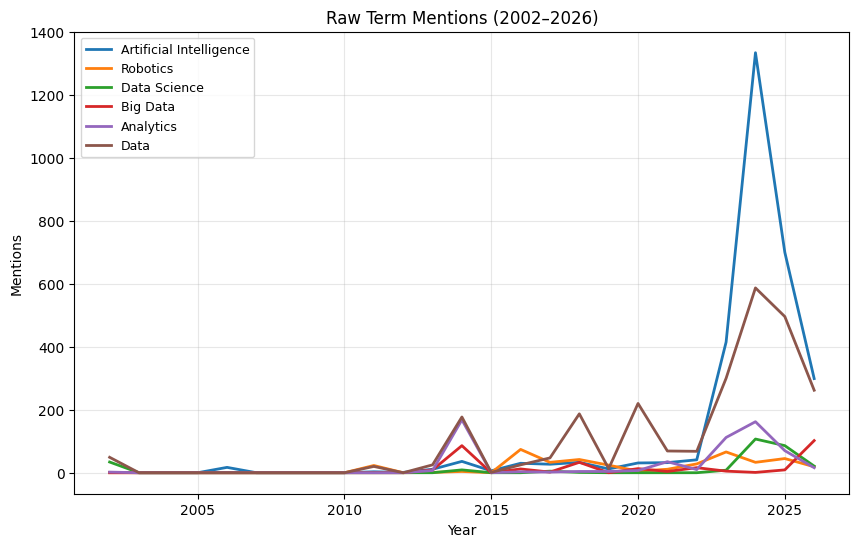

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

for term in TERMS:
    plt.plot(period_data["year"], period_data[term],
             linewidth=2, label=term.title())

plt.title("Raw Term Mentions (2002–2026)")
plt.xlabel("Year")
plt.ylabel("Mentions")
plt.legend(fontsize=9)
plt.grid(alpha=0.3)
plt.show()
